In [294]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [295]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta  

# Reflect Tables into SQLAlchemy ORM

In [296]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [297]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect() 


In [298]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True) 


In [299]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [300]:
# Save references to each table
Measurement_tbl = Base.classes.measurement 
Stattion_tbl = Base.classes.station 

In [301]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [302]:
inspector = inspect(engine)
meas= inspector.get_columns('measurement')
for c in meas:
    print('Measurement table',c['name'], c['type'])

print('------------------\n')
stat= inspector.get_columns('station')
for c in stat:
    print('Station table',c['name'], c['type'])

Measurement table id INTEGER
Measurement table station TEXT
Measurement table date TEXT
Measurement table prcp FLOAT
Measurement table tobs FLOAT
------------------

Station table id INTEGER
Station table station TEXT
Station table name TEXT
Station table latitude FLOAT
Station table longitude FLOAT
Station table elevation FLOAT


# Exploratory Precipitation Analysis

In [303]:
# Find the most recent date in the data set.

engine.execute('select * from measurement order by date desc').fetchone()

# most recent date is 2017-08-23
# earliest date is 2010-01-01

(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)

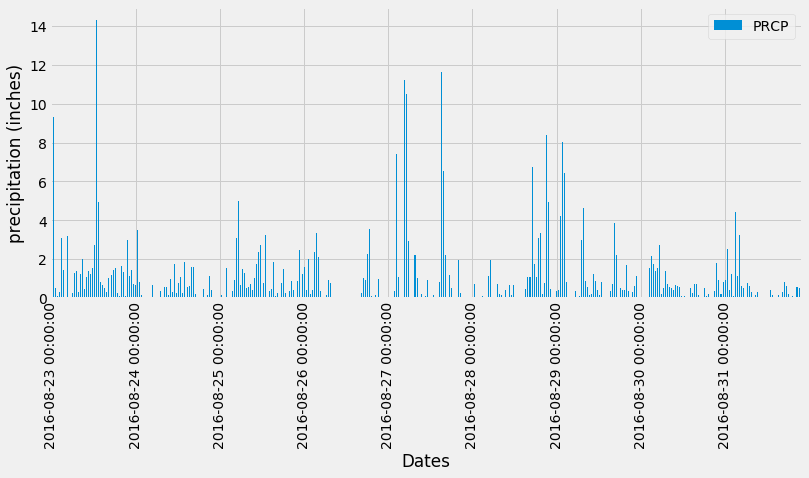

In [304]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

#pull data from measurement into a data frame meas_df
meas_df = pd.read_sql('select * from measurement order by date desc', conn)
meas_df['date'] = pd.to_datetime(meas_df['date'] )


#meas_df.head()
# Calculate the date one year from the last date in data set.
# get the last date
last_dt =  meas_df['date'].max()
# get the previous date a year from the last date
l_date =  dt_obj + timedelta(days=-365)

# Perform a query to retrieve the data and precipitation scores
df = meas_df.loc[meas_df['date']>= l_date ,  ['date', 'prcp']]


#meas_df['date'] = meas_df['date'].dt.strftime('%B')
df.set_index('date', inplace=True)

# Save the query results as a Pandas DataFrame and set the index to the date column
# already done
# Sort the dataframe by date
df.sort_values(by=['date'], ascending=False)
df_plot = df.groupby('date')

prcp = df_plot['prcp'].sum()
df_plot = pd.DataFrame({'PRCP': prcp})

#df_plot.head(30)
# Use Pandas Plotting with Matplotlib to plot the data
df_plot.plot.bar(figsize = (12,5))
plt.locator_params(axis='x', nbins=9)
plt.ylabel('precipitation (inches)')
plt.xlabel('Dates')
plt.show()


In [305]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2 = meas_df.loc[meas_df['date']>= l_date ,  ['date', 'prcp']]

# update date to month to group
df2['date'] = df2['date'].dt.strftime('%B')
df2= df2.groupby('date')
#analysis scope
rain_sum = df2['prcp'].sum()
rain_avg = df2['prcp'].mean()
rain_std = df2['prcp'].std()
rain_count = df2['prcp'].count()

df_summary = pd.DataFrame({'Total rain (inches)': rain_sum, 'Avg rain':rain_avg, 'Std Deviation':rain_std , '# times Rain': rain_count}
)
df_summary



,Total rain (inches),Avg rain,Std Deviation,# times Rain
date,,,,
April,54.91,0.321111,0.702469,171
August,25.99,0.193955,0.477401,134
December,35.51,0.199494,0.342967,178
February,39.06,0.241111,0.672922,162
January,11.95,0.070294,0.276047,170
July,23.72,0.134773,0.386084,176
June,20.52,0.120000,0.217726,171
March,29.62,0.175266,0.431165,169
May,25.27,0.151317,0.315384,167


# Exploratory Station Analysis

In [306]:
# Design a query to calculate the total number stations in the dataset
#engine.execute('select distinct station from measurement').fetchall()
engine.execute('select count(distinct station) from measurement').fetchall()

[(9,)]

In [307]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
engine.execute('select station, count(*) as "cnt" from measurement group by station order by "cnt" DESC').fetchall()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [308]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
engine.execute('select station, max(tobs) as "max_temp", min(tobs) as "minx_temp", round(avg(tobs),2) as "avg_temp"\
     from measurement where station = "USC00519281" group by station ').fetchall()

[('USC00519281', 85.0, 54.0, 71.66)]

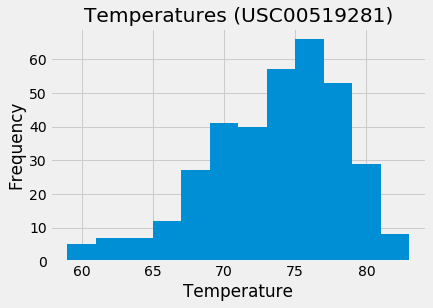

In [309]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hplot = engine.execute('select  tobs from measurement where station = "USC00519281" and date >="2016-08-23" ').fetchall()

temp_df = pd.DataFrame(hplot, columns=['Temperatures (USC00519281)'])

temp_df.hist(column='Temperatures (USC00519281)',bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()



# Close session

In [310]:
# Close Session
session.close()